## Machine Learning 101: Probabilistic Image Classification with Gaussian Naive Bayes

#### Author: Alex - Super Make Something
#### Date: 2020-06-05

#### Supplemental YouTube video: Machine Learning 101: Image classification with Naive Bayes (NVIDIA Jetson Xavier NX!)

#### Video URL: https://youtu.be/UkXMP89B2pM

One of the most common uses of machine learning is image classification, where a computer determines what it is "seeing" in an image based on various items it has seen before.  But how exactly does a machine learning algorithm go from raw pixel values to determining whether the object in an image is a dog, a cat, or a banana?  One way to do it is to use probability and a classifier known as "Gaussian Naive Bayes" (GNB).

The code below sets up, trains, and tests a GNB classifier to tell the difference between various types of fruit.  This example uses the "Fruits-360" dataset, a collection of over 90,000 100x100 pixel images of different types of fruits, vegetables, and nuts.  Images in this set are divided into separate training and testing folders, each of which contain separate additional folders for different food types.  The 761MB "Fruits-360" zip file can be downloaded [here](https://github.com/Horea94/Fruit-Images-Dataset).  This file should be unzipped into the same directory as this Jupyter Notebook.

#### Background: The image classification pipeline

<img src="img/classificationPipeline.png" width="75%">

<p style="text-align:center"><i>Illustration of the image classification pipeline.</i>

While many different types of machine learning algorithms exist to classify images, all of them follow the same basic steps.  Most two dimensional digital images are made up of an array of red, green, and blue pixel values, which must first be loaded by the program that implements the image classification algorithm.  

Once loaded, these arrays are then modified in the **pre-processing step** to adjust the image contrast and brigthness, to transform the pixel values into a different color space, or to crop and resize images so that all input images have the same size and resolution.  

After this, the **feature extraction step** extracts information or "features" from these images, which a machine learning algorithm uses to understand the content of the image.  These features can either be predetermined by the user (i.e. what is the average color of the image and how many pixels in the image are white?) or be automatically generated based on the structure of the image classification algorithm (as is the case with image classification approaches that use Artificial Neural Networks).  (The algorithm implemented in this Notebook, "Gaussian Naive Bayes," uses predetermined features that are specified by the user for image classification.  Feel free to experiment by implementing new features to see how it affects classification accuracy!)  

After all of the required features are extracted from an image, the **classification step** compares these to a library of feature values for various different objects that the image classifier has seen before during training.  It then decides what is in the image by determining the closest match between the set of pre-trained feature values and the features extracted from the input image.  

To understand what decisions our image classifier made and to test how well the image classifier works, we will pass a set of images that we know the content of into the classifier, and compare what the it thinks it sees to what is actually in the image.  This will be done by feeding images from various folders in the Fruits-360 dataset into the trainied classifier and seeing if the predicted fruit matches the folder the image came from.

*One quick bit of terminology:* Each different object type a classifier can recognize is called a <b>class</b>.  As its name suggests, a <b>class</b>ifier tries to determine what class an input image belongs to, based on all of the different classes that it encountered during the algorithm's training stage. 

#### What is Gaussian Naive Bayes?

Naive Bayes classifiers are a family of classification algorithms that use probability to determine what class an object belongs to.  Like their name suggests, these probabilistic classifiers rely on Bayes theorem, which is written as: 

\begin{equation}
P(Y|\textbf{X})\ \ \ = \ \ \ \frac{P(Y) P(\textbf{X}|Y)}{P(\textbf{X})},
\end{equation}

where $P(Y|\textbf{X})$ is the probability that a sample belongs to class $Y$ given that it has the feature values $\textbf{X}$, $P(Y)$ is the probability of randomly drawing a sample that belongs to class $Y$ out of the dataset, $P(\textbf{X}|Y)$ is the probability that a sample with feature values $X$ belongs to class $Y$, and $P(X)$ is the probability that $X$ occurs.  This value is calculated using the extracted feature values for a sample we are interested in classifying for class we want to differentiate between.  Classification is then accomplished by simply picking the class that has the highest probability.

When classifying samples into a known number of classes, $P(X)$ is a constant for all classes, so it does not need to be calculated, which makes the math easier and the classifier a bit faster.  Instead, it is possible to write 

\begin{equation}
P(Y|\textbf{X}) \ \ \ \alpha \ \ \ P(Y) P(\textbf{X}|Y),
\end{equation}

where $\alpha$ denotes that the two quantities are proportional to each other.  This means that the final calculation will not give the actual probability that this event will occur in the real world, but since we only care about the relative likelihood that a sample belongs to one of the classes we are interested in, this is okay.

<img src="img/multiFeatureClassification.png" width="75%">

<p style="text-align:center"><i>The advantage of multi-feature classification.</i>

Based on what the classifier is trying to classify, it is unlikely that a single feature will be able to perfectly categorize every sample the classifier will see.  Therefore, it is necessary to use multiple features to describe the objects in each class.  In the real-world, however, it is likely that several features depend on each other -- for example how sweet a person thinks a food is depends on the amount of sugar in the food.  This quantity is known as the joint probability, but can be incredibly difficult to calculate for all of a classifier's potential features.  
    
This is where the "naive" portion of Naive Bayes comes in -- instead of calculating the joint probability, a Naive Bayes classifier simply treats all of the features as independent, meaning that the conditional probability $P(\textbf{X}|Y=y_i)$ of a new sample with feature vector $X$ belonging to the class $y_i$ can be calculated for each feature separately, and then simply multiplied together:
    
\begin{equation}
P(Y=y_i|\textbf{X}) \ \ \ \alpha \ \ \ P(Y=y_i) \prod_{i=1}^{n}P(\textbf{X}|Y=y_i).
\end{equation}
    
The last remaining piece is to calculate the conditional probability for each feature.  One way to do this is to assume that the conditional probability for each feature follows a Gaussian distribution, where the likelihood can be described by a mean and standard deviation:

\begin{equation}
P(X|Y=y_i) =  \frac{1}{\sigma_i \sqrt{2\pi}} e^{-(x-\mu_i)^2/(2\sigma_i^2)}
\end{equation}
    
While this equation looks complicated, all that is needed to calculate the probability that a new sample belongs to a certain class is the values of that new sample's features $x$, and the mean values $\mu_i$ and standard deviations $\sigma_i$ of those features for all of the classes that you are trying to differentiate between, which is calculated from your training data.  This makes Gaussian Naive Bayes a fast and easy image classification scheme that is useful for many different scenarios.  
    
Now that we know what a Gaussian Naive Bayes classifier is, let's implement it in Python and use it to classify images!

#### Import required libraries

This classifier is built using `Matplotlib` to load and plot images, `Numpy` to manipulate image and feature arrays, and `os` to generate and create file paths and folders.  To analyze the results, the code also uses the data manipulation library `Pandas` and the data visualization library `Seaborn` to generate a confusion matrix that makes it easy to see where the classifier worked well and where it was confused.  Finally, the file operations library `shutil` is used to delete any existing results from an old run to keep everything organized and the time library is used for profiling purposes to get an estimate of how fast portions of the code execute.

The cell below first imports all of the required libraries.

Note: You can run individual Jupyter Notebook cells with SHIFT+ENTER.


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from numpy import matlib
import os
import seaborn as sn
import pandas as pd
import shutil
import time

#### Define required supporting methods

The cell below defines the <i>trainFeature_statsColors()</i> method, which loads all images in a specified training directory and calculates the mean and standard deviation of all pixels in the images' red, green, and blue color channels after tresholding out the white background.

In [2]:
def trainFeature_statsColors(trainDir):  # Calculate feature -- mean and standard deviation of RGB values

    filenames = os.listdir(trainDir)  # Get filenames in "trainDir" directory
    redVals = greenVals = blueVals = np.zeros([1, 0])  # Declare empty numpy arrays to save all red, green, and blue channel values

    for file in filenames[:-1]:  # Iterate through each picture in the specified training directory
        baseImage = plt.imread(trainDir + file)
        image = baseImage.copy()  # Create copy of the image -- workaround for write permission modification error in some versions of numpy
        image = np.reshape(image, (-1, 3))  # Reshape image into a 10,000x3 array where the first, second, and third column correspond to the red, green, and blue color value of each pixel, respectively
        image = image[~np.all(image > 250, axis=1)]  # Remove all white background pixels in the image
        redVals = np.append(redVals, image[:, 0])  # Append all red channel values of current image to redVals array
        greenVals = np.append(greenVals, image[:, 1])  # Append all green channel values of current image to greenVals array
        blueVals = np.append(blueVals, image[:, 2])  # Append all blue channel values of current image to blueVals array

    avgR = np.mean(redVals)  # Calculate the mean value of all red values
    stdR = np.std(redVals)  # Calculate the standard deviation of all red values
    avgG = np.mean(greenVals)  # Mean of all green values
    stdG = np.std(greenVals)  # Standard deviation of all all green values
    avgB = np.mean(blueVals)  # Mean of all blue values
    stdB = np.std(blueVals)  # Standard deviation of all blue values
    
    return avgR, stdR, avgG, stdG, avgB, stdB

The cell below defines the <i>trainFeature_statsWPixels()</i> method, which loads each image in a specified training directory and calculates the mean and standard deviation of the number of white background pixels in each image.  Due to the way that the dataset was generated, this value can be thought of as relating to each fruit's size and shape.

In [3]:
def trainFeature_statsWPixels(trainDir):  # Calculate feature -- mean and standard deviation of white background pixels

    filenames = os.listdir(trainDir)
    noWhitePix = np.zeros([1,0])  # Declare empty numpy array that stores the number of white background pixels in each image

    for file in filenames[:-1]:
        baseImage = plt.imread(trainDir + file)
        image = baseImage.copy()
        image = np.reshape(image, (-1, 3))
        image = image[~np.all(image < 250, axis=1)]  # Remove all non-white pixels in each image
        noWhitePix = np.append(noWhitePix, image.shape[0])  # Append number of white pixels in current image to noWhitePix array

    avgWPix = np.mean(noWhitePix)  # Calculate the mean value of number of white pixels
    stdWPix = np.std(noWhitePix)  # Calculate the standard deviation of number of white pixels
    return avgWPix, stdWPix

The next cell calculates the prior probability for each class, i.e. the probability that a sample from each class can be drawn at random.  This value is calculated simply as the number of images in each class divided by the total number of images used during training.  Calculating actual prior probabilities is hard (if not impossible for real-world image classification applications), so this calculation makes the assumption that the number of examples in each class in the training dataset is close to the number of items in each class in the testing dataset (or the classifier's chance of encountering these items at random in the real world.)

In [4]:
def calcPriors(classes, trainDir):  # Calculate prior probabilities for each class
    
    priorProb = np.empty([1,0])
    
    for item in classes:
        filenames = os.listdir(trainDir + item + '/')  # Iterate through every folder in the 'classes' list
        priorProb = np.append(priorProb,len(filenames))  # Add total number of images in that folder to an array
    
    priorProb = priorProb/np.sum(priorProb)  # Divide the number of images in a folder by the total number of images
    return priorProb

The next two cells define the <i>calcFeature_statsColor()</i> and <i>calcFeature_statsWPixels()</i> methods.  These code blocks essentially do the same thing as the <i>trainFeature_statsColor()</i> and <i>trainFeature_statsWPixels()</i> methods, but for one image, whose path is defined by the _testImgPath_ variable.

In [5]:
def calcFeature_statsColors(testImgPath):  # Calculate feature -- mean RGB values

    baseImage = plt.imread(testImgPath)
    image = baseImage.copy()
    image = np.reshape(image, (-1, 3))
    image = image[~np.all(image > 250, axis=1)]
    
    avgR = np.mean(image[:,0])  # Calculate the mean of all values in the red color channel
    avgG = np.mean(image[:,1])  # Calculate the mean of all values in the green color channel
    avgB = np.mean(image[:,2])  # Calculate the mean of all values in the blue color channel
    return avgR, avgG, avgB    

In [6]:
def calcFeature_statsWPixels(testImgPath):   # Calcuate feature -- number of white pixels in the image

    baseImage = plt.imread(testImgPath)
    image = baseImage.copy()
    image = np.reshape(image, (-1, 3))
    image = image[~np.all(image < 250, axis=1)]
    noWhitePx = image.shape[0]
    return noWhitePx

The cell below defines the <i>calcLikelihood()</i> method, which is at the heart of the GNB classification algorithm.  Using the features calculated for a given inmage, in addition to the mean and standard deviation feature arrays calculated during training, this method returns an array of conditional probabilities that describe how likely it is that an image with the given set of feature values belongs to a certain class.  Later, this array is multiplied with the prior array that was also calculated during training, in order to calculate the probability that the image belongs to each class given its feature values.  To speed up classification, the input feature array is appropriately sized to match the dimensions of the mean and standard deviation arrays so that all likelihood calculations can be done without a for loop using matrix multiplication.

In [7]:
def calcLikelihood(featureVec, meanFeatureVals, stdFeatureVals):
    
    featureLikelihood = 1/np.sqrt(2 * np.pi * stdFeatureVals ** 2) * np.exp(-1 * (featureVec - meanFeatureVals) ** 2 / (2 * stdFeatureVals ** 2))
    likelihoods = np.prod(featureLikelihood, axis=1)
    return likelihoods

#### Train the classifier

Let's first define a list of fruits we are interested in classifying and tell the algorithm where the training data is located.  Different fruits can be selected by modifying the entries in the 'classes' list.  These entries correspond to folder names within the training and testing directories.

In [13]:
classes = ['Apple Red 1', 'Banana', 'Blueberry', 'Lemon', 'Limes']  # Fruits to classify 
trainDir = "Fruit-Images-Dataset-master/Fruit-Images-Dataset-master/Training/"  # Directory of training images

Now it's time to train the classifier!  The code below calculates the mean and standard deviation of features using the training methods defined above.  After training, the array of feature values and prior probabilities are saved to file so that classification can occur later without needing to re-run training.

In [14]:
timeStart = time.time()  # Get current time

# Declare empty array to store feature values
noFeatures = 4  # Number of features
meanFeatureVals = np.empty((0, noFeatures))
stdFeatureVals = np.empty((0, noFeatures))

for fruit in classes:  # Calculate feature values for all classes listed in the 'classes' list
    print('Calculating feature values for ' + fruit + ':', end=' ')
    avgR, stdR, avgG, stdG, avgB, stdB = trainFeature_statsColors(trainDir + fruit + '/')  # Calculate R,G,B color features
    avgWPix, stdWPix = trainFeature_statsWPixels(trainDir + fruit + '/')  # Calculate number of white pixels feature
    meanFeatureVals = np.vstack((meanFeatureVals, np.array([avgR, avgG, avgB, avgWPix])))  # Save mean values into array
    stdFeatureVals = np.vstack((stdFeatureVals, np.array([stdR, stdG, stdB, stdWPix])))  # Save std values into array
    print('Done')

print('Calculating priors:', end=' ')
priorProbabilities = calcPriors(classes, trainDir)  # Calculate the prior probability for each class
print('Done')

print("Saving Array of Training Values:", end=' ')
np.savez('gnbClassifier',meanFeatureVals, stdFeatureVals, priorProbabilities)  # Save feature value and prior arrays so that they can be loaded later
print('Done')

print('Training complete!  Elapsed Time: ' + str(time.time() - timeStart) + ' seconds.')

Calculating feature values for Apple Red 1: Done
Calculating feature values for Banana: Done
Calculating feature values for Blueberry: Done
Calculating feature values for Lemon: Done
Calculating feature values for Limes: Done
Calculating priors: Done
Saving Array of Training Values: Done
Training complete!  Elapsed Time: 29.747912645339966 seconds.


#### Classifying images

Time to classify some images!  Let's begin by selecting our testing data.  The code below first re-loads the feature and prior probability arrays.  Next, it chooses ten random images from each of the trained on classes using images in the test dataset, and saves the filepath to each image into a list.  (Choosing ten items from each class violates the previous assumption that was used to calculate prior probabilities, but the number of images in each training folder is roughly equal, so this is okay.)  For development purposes, the <i>random()</i> method is seeded with a value so that the same ten images are chosen at "random" whenever the program is run.  Comment this line out to grab truly random images from each folder.  

During this process, the code also generates an array of the actual labels for each image based on which folder the image came from, which we will use later to examine how accurately the classifier identified each fruit.

In [15]:
data = np.load('gnbClassifier.npz')  # Load the .npz file containing feature value and prior arrays
meanFeatureVals = data['arr_0']  # Assign each array to a variablle
stdFeatureVals = data['arr_1']
priorProb = data['arr_2']

testDir = "Fruit-Images-Dataset-master/Fruit-Images-Dataset-master/Test/"  # Directory of testing images
np.random.seed(1)  # Seed the random number generator to generate the same "random" numbers each time
images = []  # Declare empty list to store filepaths to testing images
trueLabels = []  # Declare empty list to store true labels

for fruit in classes:
    filenames = os.listdir(testDir + fruit + '/')  # Get list of all filenames in a testing
    for i in range(10):  # Grab ten random images
        randomIndex = np.random.randint(low=0, high=len(filenames))  # Generate a random integer between [0, number of images in the folder]
        images.append(testDir + fruit + '/' + filenames[randomIndex])  # Add path to random image to list
        trueLabels.append(fruit)  # Add true label to list

Next, each image is loaded and the color and white pixel features are extracted from each image using the <i>calcFeature_statsColors()</i> and <i>calcFeature_statsWPixels()</i> methods that are defined above.  After this the likelihood that the image came from each class is calculated using the <i>calcLikelihood()</i> method, which is then multiplied with the array of prior values.  This calculation results in a set of numbers proportional to the probability that the image belongs to each of the classes given its feature values.  The number with the highest probability is the class chosen by the classifier, which is then written to the list 'chosenLabels'.

In [16]:
timeStart = time.time()  # Get current time

predLabels = []  # Declare empty list to store labels predicted by the classifier

for item in images:  # For all images in the test set
    avgR, avgG, avgB  = calcFeature_statsColors(item)  # Extract R, G, B color features
    noWhitePix = calcFeature_statsWPixels(item)  # Extract number of white pixels feature
    featureVec = np.array([avgR, avgG, avgB, noWhitePix])  # Place all features into an array
    featureVec = np.matlib.repmat(featureVec, len(classes), 1)  # Replicate the array to match the feature array size for matrix multiplication
    likelihoods = calcLikelihood(featureVec, meanFeatureVals, stdFeatureVals)  # Calculate likelihoods
    posteriorProb = likelihoods*priorProb  # Multiply the likelihoods with the prior probabilities
    predClass = np.argmax(posteriorProb)  # Find the index with the largest probability
    predLabels.append(classes[predClass])  # Add predicted label to list

print('Classification complete!  Elapsed Time: ' + str(time.time() - timeStart) + ' seconds.')

Classification complete!  Elapsed Time: 0.05695295333862305 seconds.


#### Evaluating classifier performance

Time to find out how well the classifier worked!  To do this, we will generate a confusion matrix, a table of values that makes it easily to see items were classified correctly and which items the classifier confused.   To look at individual results in more detail, the classifier also writes each test image overlaid with the chosen label to a folder called 'Results.'  For a full explanation of the results generated with this code, check out the corresponding episode on YouTube.

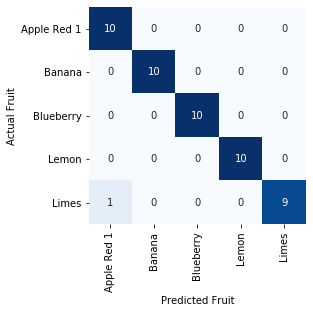

Individual classification results saved to the 'Results/' directory.


In [17]:
confusionMatrix = pd.crosstab(pd.Series(trueLabels), pd.Series(predLabels))  # Cross-tabulate actual and predicted labels
sn.heatmap(confusionMatrix, cbar=False, annot=True, cmap='Blues', square=True)  # Create heatmap
plt.xlabel("Predicted Fruit")  # Add labels
plt.ylabel("Actual Fruit")
plt.show()  # Show the plot

resultsFolder = 'Results/'  # Specify results folder
resFilenames = [sub.replace(testDir, resultsFolder) for sub in images]  # Generate filenames for saving annotated results

if os.path.exists(resultsFolder):  # Remove any existing results
        shutil.rmtree(resultsFolder)

for fruit in classes:  # Create directories in which to save results
    if not os.path.exists(resultsFolder + fruit + '/'): #check for existence of results directory
        os.makedirs(resultsFolder + fruit + '/') #create it if it doesn't exist

for index, item in enumerate(images):  # Iterate through all test images
    baseImage = plt.imread(item)
    plt.imshow(baseImage)
    plt.axis('off')
    if trueLabels[index] == predLabels[index]:  # If the actual and predicted label match
        plt.text(0, 0, predLabels[index], bbox=dict(facecolor='green', alpha=0.5))  # Overlay green box with predicted label
    else:  # If the actual and predict label do not match
        plt.text(0, 0, predLabels[index], bbox=dict(facecolor='red', alpha=0.5))  # Overlay red box with predicted label
    plt.savefig(resFilenames[index])  # Save the annotated image
    plt.close()
    
print('Individual classification results saved to the \'' + resultsFolder + '\' directory.')

### Conclusion

Gaussian Naive Bayes classifiers are an intuitive, simple, and computationally inexpensive way to classify images.  While this example focused on classifying whole images that only contained a single object, this approach could also be used on a subset of pixels in images to identify multiple objects or to accomplish image segmentation, or on an entirely different data format like sound files or text.  Feel free to use this code as a jumping off point for implementing your own GNB classifier and experiment with different classes and features!

If you liked this tutorial and want to see other cool projects, please consider subscribing to [Super Make Something channel on YouTube](https://www.youtube.com/supermakesomething)!  Also feel free to get in touch about other Machine Learning topics you would like to see covered on the channel!  Thanks for checking this tutorial out and be sure to [like the video that accompanies this code](https://youtu.be/UkXMP89B2pM) -- now go Super Make Something!